#### 1. Import dependancies

In [108]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.optim import SGD
from torchvision import datasets
from torchvision.transforms import transforms, Compose
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### 2. Load Data with Dataloader

In [104]:
# hyperparameters
# sample shape = torch.Size([100, 3, 32, 32])
# label shape = torch.Size([100])

input_shape = 32*32

in_channels = 3 # rgb
kernel_size = 5
pool_kernel_size = 2
stride = 2

classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')
batch_size = 120

learning_rate = 0.5
epochs = 10


In [117]:
transform_composed = Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

train_data = torchvision.datasets.CIFAR10(root = r'./data', train=True, download=True, transform=transform_composed)
test_data = torchvision.datasets.CIFAR10(root = r'./data', train=False, download=True, transform=transform_composed)

train_data_loader = DataLoader(dataset = train_data, batch_size= 100, shuffle = True, num_workers= 0)
test_data_loader = DataLoader(dataset = test_data, batch_size= 100, shuffle = False, num_workers= 0)


Files already downloaded and verified
Files already downloaded and verified


torch.Size([100, 3, 32, 32])
torch.Size([100])


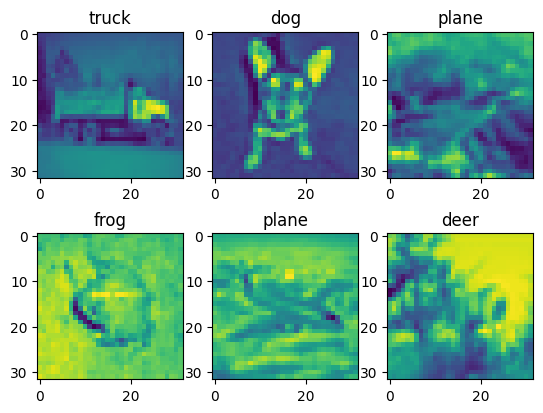

In [113]:
example = iter(train_data_loader)
sample, labels = example.__next__()

print(sample.shape)
print(labels.shape)

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(sample[i][0])
    plt.title(classes[labels[i]])
plt.show()

#### 3. Create CNN class 

In [114]:
# Define the ConvNet model
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # conv2D -> ReLU -> pool
        
        # after conv1 layer above we will obtain img.shape of 
        # img.shape = (4,3,32,32)
        # new_dim_after_conv = input_dim - filter_size + (2*(padding)/stride) +1
        #     = 32 - 5 + (2*0/2) +1  = 27 + (0) + 1 = 28
        # new img.shape = (4, 6, 28, 28) -> here the 6 is the out_channels from conv1 later
        # now apply pooling - new_dims = ((input_dim - pool_kernel_size)/stride)+1 = ((28 - 2)/2)+1 = (26/2)+1 = 13+1 = 14
        # new img.shape = (4,6,14,14) -> updated the image size after applying pooling
        
        # we do this entire process one more time for the conv2 layer
        # we get the final img.shape as (4,16,5,5)
        # here  4 is batch size, 16 is out_channels of conv2 layer and 5,5 is the image dims after applying pooling for the second time
        # hence the input size for the linear layer will be 16(channels) * 5(rows) *5 (columns) = 16*5*5        
        
        x = self.pool(F.relu(self.conv2(x))) # conv2D -> ReLU -> pool
        x = x.view(-1, 16*5*5) # flatten before sending it to linear layer
        x = F.relu(self.fc1(x)) # send to fully connected layers
        x = F.relu(self.fc2(x))
        x = self.fc3(x) # no softmax as we are going to use crossentropyloss hence softmax will be applied automatically
        return x

#### 4. Create instance of the ConvNet class, optimizer and loss

In [115]:
# Instantiate the model, define the criterion and optimizer
model = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9) # Adjust the learning rate and add momentum


#### 5. Training the model

In [121]:
# Training loop
for epoch in range(epochs):
    model.train()
    for i, (images, labels) in enumerate(train_data_loader):
        # forward pass
        y_pred = model(images)
        
        # calculate loss
        loss = criterion(y_pred, labels)
        
        # calculate gradients and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print(f'Epoch: {epoch+1}/{epochs}, Step: {i+1}/{steps}, Loss: {loss.item():.4f}')
    
    # Evaluation after each epoch
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0

    with torch.no_grad():
        for images, labels in test_data_loader:
            output = model(images)
            loss = criterion(output, labels)
            total_loss += loss.item() * images.size(0) # accumulate loss
            
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
    acc = 100 * correct / total
    avg_loss = total_loss / total
    print(f'Accuracy: {acc:.2f}%, Avg Loss: {avg_loss:.4f}')


Files already downloaded and verified
Files already downloaded and verified
Epoch: 1/10, Step: 100/500, Loss: 2.0716
Epoch: 1/10, Step: 200/500, Loss: 1.8431
Epoch: 1/10, Step: 300/500, Loss: 1.7305
Epoch: 1/10, Step: 400/500, Loss: 1.5010
Epoch: 1/10, Step: 500/500, Loss: 1.6721
Accuracy: 42.67%, Avg Loss: 1.6020
Epoch: 2/10, Step: 100/500, Loss: 1.4020
Epoch: 2/10, Step: 200/500, Loss: 1.6432
Epoch: 2/10, Step: 300/500, Loss: 1.3722
Epoch: 2/10, Step: 400/500, Loss: 1.3821
Epoch: 2/10, Step: 500/500, Loss: 1.4437
Accuracy: 51.08%, Avg Loss: 1.3702
Epoch: 3/10, Step: 100/500, Loss: 1.2869
Epoch: 3/10, Step: 200/500, Loss: 1.4620
Epoch: 3/10, Step: 300/500, Loss: 1.3383
Epoch: 3/10, Step: 400/500, Loss: 1.0513
Epoch: 3/10, Step: 500/500, Loss: 1.3268
Accuracy: 55.72%, Avg Loss: 1.2569
Epoch: 4/10, Step: 100/500, Loss: 1.2956
Epoch: 4/10, Step: 200/500, Loss: 1.0998
Epoch: 4/10, Step: 300/500, Loss: 1.1623
Epoch: 4/10, Step: 400/500, Loss: 1.2515
Epoch: 4/10, Step: 500/500, Loss: 1.2347